# Computer Vision: Assignment 3 Part 1 - Some CNN Basics [50%]

Spring 2022 semester.

Due date: **July 1st 2022.**

## Introduction

This question is an introduction to using PyTorch for training simple neural net models. 

Two different datasets will be used: 
- MNIST digits [handwritten digits]
- CIFAR-10 [32x32 resolution color images of 10 object classes].

## Requirements

Perform this assignment in PyTorch, modifying the baseline code, producing outputs and adding required explanations - *all within this ipython notebook*.

Finally, submit this iPython notebook, including outputs, as an .ipynb file. 

## Question (1): Warmup [5%]

It is always good practice to visually inspect your data before trying to train a model, since it lets you check for problems and get a feel for the task at hand.

MNIST is a dataset of 70,000 grayscale hand-written digits (0 through 9).
60,000 of these are training images. 10,000 are a held out test set. 

CIFAR-10 is a dataset of 60,000 color images (32 by 32 resolution) across 10 classes (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck). 
The train/test split is 50k/10k.

**a)**  Use `matplotlib` and ipython notebook's visualization capabilities to display the average train and average test image of each class, for each of the two datasets.
[See this PyTorch tutorial page](http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) for hints on how to achieve this.

## Question (2): Training a Single Layer Network on MNIST [10%]

Start by running the training on MNIST. By default if you run this notebook successfully, it will train on MNIST.

This will initialize a single layer model train it on the 60,000 MNIST training images for 10 epochs (passes through the training data). 

The cross-entropy loss function computes a Logarithm of the Softmax on the output of the neural network, and then computes the negative log-likelihood w.r.t. the given target.

The default values for the learning rate, batch size and number of epochs are given in the "options" cell of this notebook. Unless otherwise specified, use the default values throughout this assignment. 

Note the decrease in training loss and corresponding decrease in validation errors.

**a)** Add code to plot out the network weights as images (one for each class, of size 28 by 28) after the last epoch. (Hint thread: [#1](https://discuss.pytorch.org/t/understanding-deep-network-visualize-weights/2060/2?u=smth) )

**b)** Reduce the number of training examples to just 50. [Hint: limit the iterator in the `train` function]. 
Paste the output into your report and explain what is happening to the model.

## Question (3): Training a Multi-Layer Network on MNIST [10%]

**a)**  Add an extra layer to the network with 1000 hidden units and a `tanh` non-linearity. [Hint: modify the `Net` class].

**b)**   Now retrain the model for 10 epochs with each of the learning rates in the set {0.01, 0.1, 1, 10} and test the resulting model. Create a figure and plot the loss curves of each of the four runs for comparison. Explain the obtained (train and test) results.

## Question (4): Training a Convolutional Network on CIFAR [15%]

To change over to the CIFAR-10 dataset, change the `options` cell's `dataset` variable to `'cifar10'`.

- Create a convolutional network with the following architecture:
  - Convolution with 5 by 5 filters, stride 2, 16 feature maps + Tanh nonlinearity.
  - Convolution with 3 by 3 filters, (stride 1), 64 feature maps + Tanh nonlinearity.
  - Convolution with 3 by 3 filters, (stride 1), 64 feature maps + Tanh nonlinearity.
  - 2 by 2 max pooling (non-overlapping).
  - Flatten to vector.
  - Linear layer with 64 hidden units + Tanh nonlinearity.
  - Linear layer to 10 output units.

**a)** Train it for 20 epochs on CIFAR-10 and plot the training loss curve (avg. loss per epoch) and final test loss and accuracy, when training with or without the two 3x3 convolutional layers. 

**b)**  Give a breakdown of the number of parameters (per layer) within the above model, as well as the overall number.

# **Answer (1):**
create needed blocks of code (and results) below

In [58]:
# imports
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import torchvision.models as models

import torchvision
import matplotlib.pyplot as plt
import numpy as np
import math

import matplotlib
from matplotlib.ticker import MaxNLocator

In [59]:
def imshow(img1, img2, dataset, label):
    img1 = img1 / 2 + 0.5  # un-normalize
    img2 = img2 / 2 + 0.5
    np_img1, np_img2 = img1.numpy(), img2.numpy()

    plt.figure()
    plt.suptitle(dataset + " dataset average: Class " + label)
    plt.subplot(1, 2, 1)
    plt.imshow(np.transpose(np_img1, (1, 2, 0)))
    plt.title('Train')
    plt.subplot(1, 2, 2)
    plt.imshow(np.transpose(np_img2, (1, 2, 0)))
    plt.title('Test')
    plt.show()

In [60]:
def show_average_images(train_loader, test_loader, dataset, labels):
    '''Plots the average image for each class in the dataset both for the training data and the test one'''
    
    train_counters, test_counters = [], []
    train_results, test_results = [], []
    
    for _ in range(len(labels)):
        train_counters.append(0)
        test_counters.append(0)
        train_results.append(None)
        test_results.append(None)
    
    dataiter = iter(train_loader)
    
    while True:
        try:
            img_temp, label_temp = dataiter.next()
            
            mn_value = torch.min(img_temp)
            mx_value = torch.max(img_temp)
            
            img_temp -= mn_value
            
            img_temp /= (mx_value - mn_value)
            
            for ind in range(len(labels)):
                if str(label_temp) == 'tensor([' + str(ind) + '])':
                    train_counters[ind] += 1
                    if train_results[ind] is None:
                        train_results[ind] = img_temp
                    else:
                        train_results[ind] += img_temp

        except StopIteration:
            break

    dataiter = iter(test_loader)
    
    while True:
        try:
            img_temp, label_temp = dataiter.next()
            
            mn_value = torch.min(img_temp)
            mx_value = torch.max(img_temp)
            
            img_temp -= mn_value
            
            img_temp /= (mx_value - mn_value)
            
            for ind in range(len(labels)):
                if str(label_temp) == 'tensor([' + str(ind) + '])':
                    test_counters[ind] += 1
                    if test_results[ind] is None:
                        test_results[ind] = img_temp
                    else:
                        test_results[ind] += img_temp

        except StopIteration:
            break
    
    for index, label in enumerate(labels):
        
        test_results[index] /= test_counters[index]
        train_results[index] /= train_counters[index]

        imshow(torchvision.utils.make_grid(train_results[index]), torchvision.utils.make_grid(test_results[index]), 
               dataset, labels[index])

Files already downloaded and verified
Files already downloaded and verified


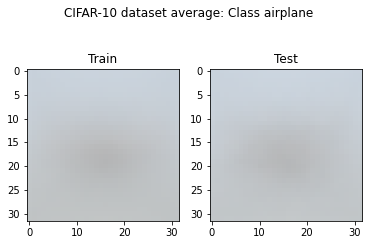

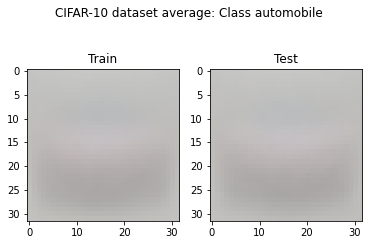

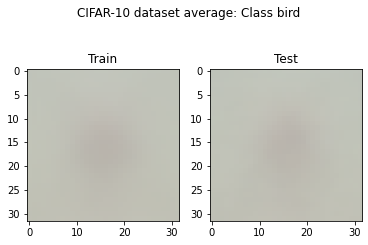

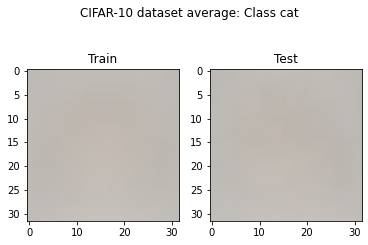

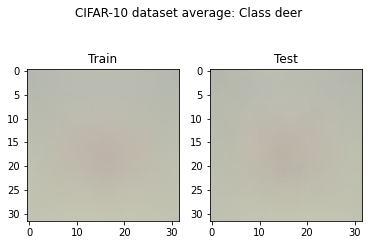

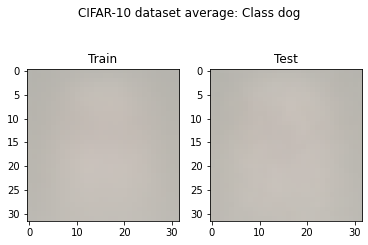

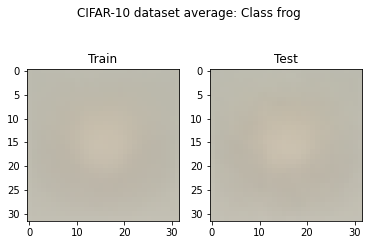

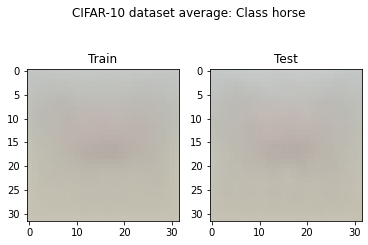

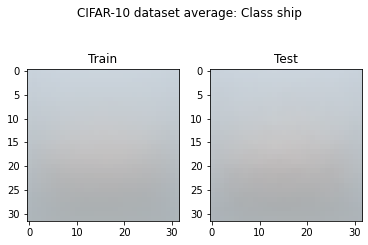

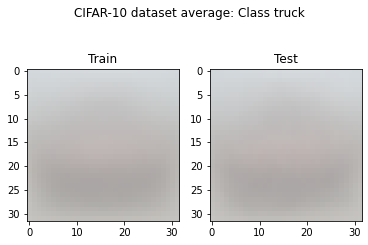

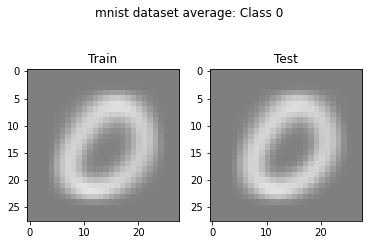

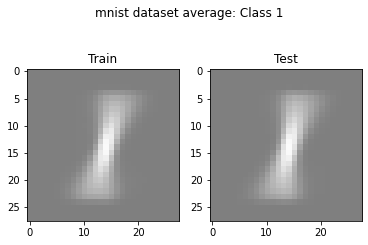

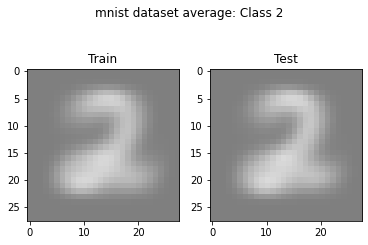

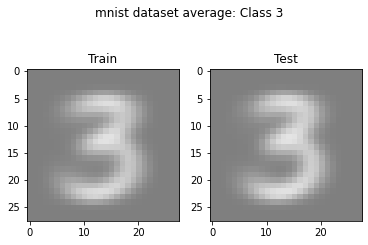

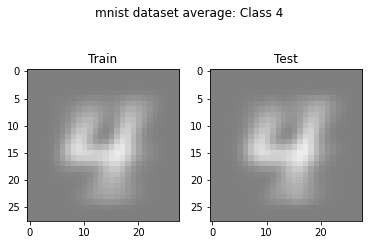

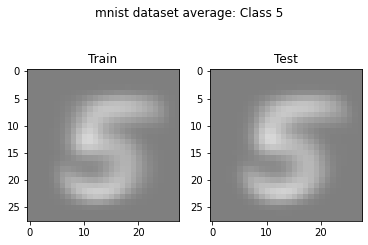

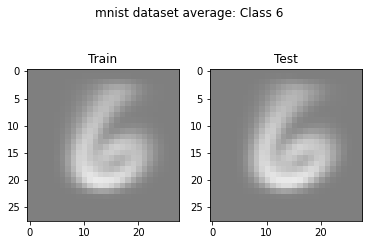

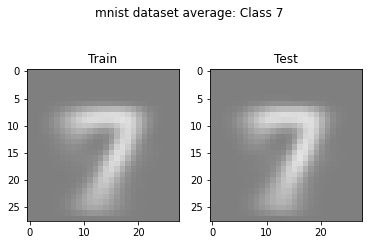

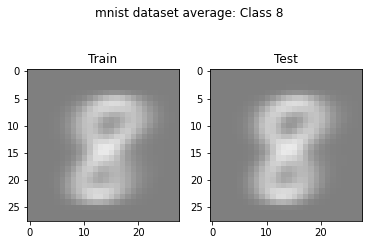

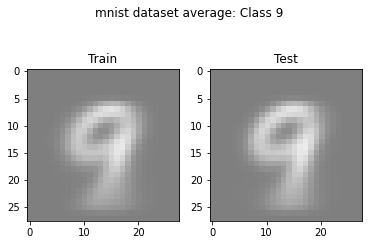

In [61]:
torch.utils.data.DataLoader.num_worker = 0

# building the transforms and data loaders

cifar_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

mnist_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))])

cifar_train = torchvision.datasets.CIFAR10(root='.', train=True,
                                           download=True, transform=cifar_transform)

cifar_train_loader = torch.utils.data.DataLoader(cifar_train, batch_size=1,
                                                 shuffle=True, num_workers=2)

cifar_test = torchvision.datasets.CIFAR10(root='.', train=False,
                                          download=True, transform=cifar_transform)

cifar_test_loader = torch.utils.data.DataLoader(cifar_test, batch_size=1,
                                                shuffle=False, num_workers=2)

mnist_train = torchvision.datasets.MNIST(root='.', train=True,
                                         download=True, transform=mnist_transform)

mnist_train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=1,
                                                 shuffle=True, num_workers=2)

mnist_test = torchvision.datasets.MNIST(root='.', train=False,
                                        download=True, transform=mnist_transform)

mnist_test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=1,
                                                shuffle=False, num_workers=2)

cifar_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
mnist_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

show_average_images(cifar_train_loader, cifar_test_loader, 'CIFAR-10', cifar_labels)
show_average_images(mnist_train_loader, mnist_test_loader, 'mnist', mnist_labels)

# **Answer (2):**
create needed blocks of code (and results) below

In [62]:
# options
dataset = 'mnist' # options: 'mnist' | 'cifar10'
batch_size = 64   # input batch size for training
epochs = 10       # number of epochs to train
lr = 0.01        # learning rate

In [63]:
## network and optimizer
if dataset == 'mnist':
    num_inputs = 784
elif dataset == 'cifar10':
    num_inputs = 3072

num_outputs = 10 # same for both CIFAR10 and MNIST, both have 10 classes as outputs

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(Net, self).__init__()
        self.linear = nn.Linear(num_inputs, num_outputs)

    def forward(self, input):
        input = input.view(-1, num_inputs) # reshape input to batch x num_inputs
        output = self.linear(input)
        return output

network = Net(num_inputs, num_outputs)
optimizer = optim.SGD(network.parameters(), lr=lr)

In [64]:
# train and test functions
def train(epoch, train_loader):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = network(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(test_loader):
    network.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        #data, target = Variable(data, volatile=True), Variable(target)
        output = network(data)
        test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
        #test_loss += F.cross_entropy(output, target, sum=True).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [65]:
# Training and testing 
for i in range(1, epochs+1):
  train(i, mnist_train_loader)

# resetting the value of batch size in the DataLoader objects
cifar_train_loader = torch.utils.data.DataLoader(cifar_train, batch_size=batch_size,
                                                 shuffle=True, num_workers=2)

cifar_test_loader = torch.utils.data.DataLoader(cifar_test, batch_size=batch_size,
                                                shuffle=False, num_workers=2)

mnist_train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size,
                                                 shuffle=True, num_workers=2)

mnist_test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size,
                                                shuffle=False, num_workers=2)

test(mnist_test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 1.865185
Train Epoch: 1 [100/60000 (0%)]	Loss: 0.621759
Train Epoch: 1 [200/60000 (0%)]	Loss: 0.281507
Train Epoch: 1 [300/60000 (0%)]	Loss: 0.000001
Train Epoch: 1 [400/60000 (1%)]	Loss: 4.151521
Train Epoch: 1 [500/60000 (1%)]	Loss: 0.000000
Train Epoch: 1 [600/60000 (1%)]	Loss: 0.001667
Train Epoch: 1 [700/60000 (1%)]	Loss: 0.000137
Train Epoch: 1 [800/60000 (1%)]	Loss: 0.157591
Train Epoch: 1 [900/60000 (2%)]	Loss: 0.000001
Train Epoch: 1 [1000/60000 (2%)]	Loss: 4.894163
Train Epoch: 1 [1100/60000 (2%)]	Loss: 0.044959
Train Epoch: 1 [1200/60000 (2%)]	Loss: 0.135426
Train Epoch: 1 [1300/60000 (2%)]	Loss: 0.136825
Train Epoch: 1 [1400/60000 (2%)]	Loss: 0.104834
Train Epoch: 1 [1500/60000 (2%)]	Loss: 0.000398
Train Epoch: 1 [1600/60000 (3%)]	Loss: 0.000167
Train Epoch: 1 [1700/60000 (3%)]	Loss: 0.445076
Train Epoch: 1 [1800/60000 (3%)]	Loss: 0.013451
Train Epoch: 1 [1900/60000 (3%)]	Loss: 0.136399
Train Epoch: 1 [2000/60000 (3%)]	Loss: 0.002023
Trai

Train Epoch: 1 [16900/60000 (28%)]	Loss: 0.002206
Train Epoch: 1 [17000/60000 (28%)]	Loss: 0.002890
Train Epoch: 1 [17100/60000 (28%)]	Loss: 0.000908
Train Epoch: 1 [17200/60000 (29%)]	Loss: 2.340299
Train Epoch: 1 [17300/60000 (29%)]	Loss: 0.002589
Train Epoch: 1 [17400/60000 (29%)]	Loss: 0.000000
Train Epoch: 1 [17500/60000 (29%)]	Loss: 26.757544
Train Epoch: 1 [17600/60000 (29%)]	Loss: 0.000005
Train Epoch: 1 [17700/60000 (30%)]	Loss: 0.000007
Train Epoch: 1 [17800/60000 (30%)]	Loss: 0.016772
Train Epoch: 1 [17900/60000 (30%)]	Loss: 0.002725
Train Epoch: 1 [18000/60000 (30%)]	Loss: 0.000001
Train Epoch: 1 [18100/60000 (30%)]	Loss: 0.000008
Train Epoch: 1 [18200/60000 (30%)]	Loss: 0.000000
Train Epoch: 1 [18300/60000 (30%)]	Loss: 14.291467
Train Epoch: 1 [18400/60000 (31%)]	Loss: 0.000000
Train Epoch: 1 [18500/60000 (31%)]	Loss: 0.000065
Train Epoch: 1 [18600/60000 (31%)]	Loss: 0.001794
Train Epoch: 1 [18700/60000 (31%)]	Loss: 0.366351
Train Epoch: 1 [18800/60000 (31%)]	Loss: 0.00028

Train Epoch: 1 [33300/60000 (56%)]	Loss: 0.000000
Train Epoch: 1 [33400/60000 (56%)]	Loss: 7.980203
Train Epoch: 1 [33500/60000 (56%)]	Loss: 0.000044
Train Epoch: 1 [33600/60000 (56%)]	Loss: 7.073624
Train Epoch: 1 [33700/60000 (56%)]	Loss: 0.000223
Train Epoch: 1 [33800/60000 (56%)]	Loss: 0.054353
Train Epoch: 1 [33900/60000 (56%)]	Loss: 0.015115
Train Epoch: 1 [34000/60000 (57%)]	Loss: 0.330932
Train Epoch: 1 [34100/60000 (57%)]	Loss: 0.000001
Train Epoch: 1 [34200/60000 (57%)]	Loss: 0.000102
Train Epoch: 1 [34300/60000 (57%)]	Loss: 0.000126
Train Epoch: 1 [34400/60000 (57%)]	Loss: 0.000000
Train Epoch: 1 [34500/60000 (58%)]	Loss: 0.000002
Train Epoch: 1 [34600/60000 (58%)]	Loss: 0.000000
Train Epoch: 1 [34700/60000 (58%)]	Loss: 0.000000
Train Epoch: 1 [34800/60000 (58%)]	Loss: 0.000000
Train Epoch: 1 [34900/60000 (58%)]	Loss: 0.000149
Train Epoch: 1 [35000/60000 (58%)]	Loss: 0.000075
Train Epoch: 1 [35100/60000 (58%)]	Loss: 0.000001
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.000001


Train Epoch: 1 [49700/60000 (83%)]	Loss: 0.000000
Train Epoch: 1 [49800/60000 (83%)]	Loss: 0.002307
Train Epoch: 1 [49900/60000 (83%)]	Loss: 0.000000
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.000017
Train Epoch: 1 [50100/60000 (84%)]	Loss: 0.000000
Train Epoch: 1 [50200/60000 (84%)]	Loss: 0.001641
Train Epoch: 1 [50300/60000 (84%)]	Loss: 0.000000
Train Epoch: 1 [50400/60000 (84%)]	Loss: 0.000000
Train Epoch: 1 [50500/60000 (84%)]	Loss: 0.000048
Train Epoch: 1 [50600/60000 (84%)]	Loss: 0.000977
Train Epoch: 1 [50700/60000 (84%)]	Loss: 0.000000
Train Epoch: 1 [50800/60000 (85%)]	Loss: 0.000000
Train Epoch: 1 [50900/60000 (85%)]	Loss: 0.011385
Train Epoch: 1 [51000/60000 (85%)]	Loss: 7.862781
Train Epoch: 1 [51100/60000 (85%)]	Loss: 0.000000
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.000006
Train Epoch: 1 [51300/60000 (86%)]	Loss: 0.000000
Train Epoch: 1 [51400/60000 (86%)]	Loss: 0.000000
Train Epoch: 1 [51500/60000 (86%)]	Loss: 0.000000
Train Epoch: 1 [51600/60000 (86%)]	Loss: 0.000000


Train Epoch: 2 [6500/60000 (11%)]	Loss: 0.000000
Train Epoch: 2 [6600/60000 (11%)]	Loss: 1.387637
Train Epoch: 2 [6700/60000 (11%)]	Loss: 0.000107
Train Epoch: 2 [6800/60000 (11%)]	Loss: 0.000000
Train Epoch: 2 [6900/60000 (12%)]	Loss: 5.319716
Train Epoch: 2 [7000/60000 (12%)]	Loss: 0.000086
Train Epoch: 2 [7100/60000 (12%)]	Loss: 0.000000
Train Epoch: 2 [7200/60000 (12%)]	Loss: 0.000000
Train Epoch: 2 [7300/60000 (12%)]	Loss: 0.000000
Train Epoch: 2 [7400/60000 (12%)]	Loss: 0.000041
Train Epoch: 2 [7500/60000 (12%)]	Loss: 0.818797
Train Epoch: 2 [7600/60000 (13%)]	Loss: 0.001170
Train Epoch: 2 [7700/60000 (13%)]	Loss: 0.000000
Train Epoch: 2 [7800/60000 (13%)]	Loss: 0.000160
Train Epoch: 2 [7900/60000 (13%)]	Loss: 0.000000
Train Epoch: 2 [8000/60000 (13%)]	Loss: 0.000007
Train Epoch: 2 [8100/60000 (14%)]	Loss: 0.000106
Train Epoch: 2 [8200/60000 (14%)]	Loss: 0.000722
Train Epoch: 2 [8300/60000 (14%)]	Loss: 0.006190
Train Epoch: 2 [8400/60000 (14%)]	Loss: 0.000053
Train Epoch: 2 [8500

Train Epoch: 2 [23300/60000 (39%)]	Loss: 1.155780
Train Epoch: 2 [23400/60000 (39%)]	Loss: 0.000001
Train Epoch: 2 [23500/60000 (39%)]	Loss: 0.000005
Train Epoch: 2 [23600/60000 (39%)]	Loss: 0.000015
Train Epoch: 2 [23700/60000 (40%)]	Loss: 0.000006
Train Epoch: 2 [23800/60000 (40%)]	Loss: 0.026892
Train Epoch: 2 [23900/60000 (40%)]	Loss: 0.137327
Train Epoch: 2 [24000/60000 (40%)]	Loss: 5.336545
Train Epoch: 2 [24100/60000 (40%)]	Loss: 0.000000
Train Epoch: 2 [24200/60000 (40%)]	Loss: 0.001014
Train Epoch: 2 [24300/60000 (40%)]	Loss: 0.160652
Train Epoch: 2 [24400/60000 (41%)]	Loss: 0.000147
Train Epoch: 2 [24500/60000 (41%)]	Loss: 0.000000
Train Epoch: 2 [24600/60000 (41%)]	Loss: 0.156871
Train Epoch: 2 [24700/60000 (41%)]	Loss: 0.000000
Train Epoch: 2 [24800/60000 (41%)]	Loss: 0.000000
Train Epoch: 2 [24900/60000 (42%)]	Loss: 0.000230
Train Epoch: 2 [25000/60000 (42%)]	Loss: 0.009870
Train Epoch: 2 [25100/60000 (42%)]	Loss: 0.000000
Train Epoch: 2 [25200/60000 (42%)]	Loss: 0.000000


Train Epoch: 2 [39700/60000 (66%)]	Loss: 0.005063
Train Epoch: 2 [39800/60000 (66%)]	Loss: 0.020742
Train Epoch: 2 [39900/60000 (66%)]	Loss: 0.000000
Train Epoch: 2 [40000/60000 (67%)]	Loss: 1.265145
Train Epoch: 2 [40100/60000 (67%)]	Loss: 0.001825
Train Epoch: 2 [40200/60000 (67%)]	Loss: 1.246797
Train Epoch: 2 [40300/60000 (67%)]	Loss: 0.000005
Train Epoch: 2 [40400/60000 (67%)]	Loss: 0.000000
Train Epoch: 2 [40500/60000 (68%)]	Loss: 0.003831
Train Epoch: 2 [40600/60000 (68%)]	Loss: 0.000229
Train Epoch: 2 [40700/60000 (68%)]	Loss: 0.214940
Train Epoch: 2 [40800/60000 (68%)]	Loss: 0.000137
Train Epoch: 2 [40900/60000 (68%)]	Loss: 0.000000
Train Epoch: 2 [41000/60000 (68%)]	Loss: 0.004780
Train Epoch: 2 [41100/60000 (68%)]	Loss: 0.000000
Train Epoch: 2 [41200/60000 (69%)]	Loss: 0.000002
Train Epoch: 2 [41300/60000 (69%)]	Loss: 0.000000
Train Epoch: 2 [41400/60000 (69%)]	Loss: 0.002208
Train Epoch: 2 [41500/60000 (69%)]	Loss: 0.000002
Train Epoch: 2 [41600/60000 (69%)]	Loss: 0.000001


Train Epoch: 2 [56300/60000 (94%)]	Loss: 0.000000
Train Epoch: 2 [56400/60000 (94%)]	Loss: 0.000082
Train Epoch: 2 [56500/60000 (94%)]	Loss: 0.000000
Train Epoch: 2 [56600/60000 (94%)]	Loss: 0.000000
Train Epoch: 2 [56700/60000 (94%)]	Loss: 0.000262
Train Epoch: 2 [56800/60000 (95%)]	Loss: 0.000006
Train Epoch: 2 [56900/60000 (95%)]	Loss: 0.058224
Train Epoch: 2 [57000/60000 (95%)]	Loss: 0.001317
Train Epoch: 2 [57100/60000 (95%)]	Loss: 0.000024
Train Epoch: 2 [57200/60000 (95%)]	Loss: 0.000075
Train Epoch: 2 [57300/60000 (96%)]	Loss: 0.000028
Train Epoch: 2 [57400/60000 (96%)]	Loss: 0.000057
Train Epoch: 2 [57500/60000 (96%)]	Loss: 0.000043
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.000223
Train Epoch: 2 [57700/60000 (96%)]	Loss: 0.005288
Train Epoch: 2 [57800/60000 (96%)]	Loss: 0.015762
Train Epoch: 2 [57900/60000 (96%)]	Loss: 0.000013
Train Epoch: 2 [58000/60000 (97%)]	Loss: 0.000252
Train Epoch: 2 [58100/60000 (97%)]	Loss: 0.000032
Train Epoch: 2 [58200/60000 (97%)]	Loss: 0.073719


Train Epoch: 3 [13600/60000 (23%)]	Loss: 0.000000
Train Epoch: 3 [13700/60000 (23%)]	Loss: 0.000000
Train Epoch: 3 [13800/60000 (23%)]	Loss: 0.000057
Train Epoch: 3 [13900/60000 (23%)]	Loss: 0.000004
Train Epoch: 3 [14000/60000 (23%)]	Loss: 0.000000
Train Epoch: 3 [14100/60000 (24%)]	Loss: 0.000016
Train Epoch: 3 [14200/60000 (24%)]	Loss: 0.000004
Train Epoch: 3 [14300/60000 (24%)]	Loss: 0.000356
Train Epoch: 3 [14400/60000 (24%)]	Loss: 0.000531
Train Epoch: 3 [14500/60000 (24%)]	Loss: 0.005704
Train Epoch: 3 [14600/60000 (24%)]	Loss: 0.000000
Train Epoch: 3 [14700/60000 (24%)]	Loss: 0.001279
Train Epoch: 3 [14800/60000 (25%)]	Loss: 0.120439
Train Epoch: 3 [14900/60000 (25%)]	Loss: 0.000004
Train Epoch: 3 [15000/60000 (25%)]	Loss: 0.004424
Train Epoch: 3 [15100/60000 (25%)]	Loss: 0.000333
Train Epoch: 3 [15200/60000 (25%)]	Loss: 0.001102
Train Epoch: 3 [15300/60000 (26%)]	Loss: 0.000000
Train Epoch: 3 [15400/60000 (26%)]	Loss: 0.000000
Train Epoch: 3 [15500/60000 (26%)]	Loss: 0.000349


Train Epoch: 3 [30200/60000 (50%)]	Loss: 0.002665
Train Epoch: 3 [30300/60000 (50%)]	Loss: 0.000000
Train Epoch: 3 [30400/60000 (51%)]	Loss: 0.000086
Train Epoch: 3 [30500/60000 (51%)]	Loss: 0.326832
Train Epoch: 3 [30600/60000 (51%)]	Loss: 12.595485
Train Epoch: 3 [30700/60000 (51%)]	Loss: 0.000000
Train Epoch: 3 [30800/60000 (51%)]	Loss: 0.004812
Train Epoch: 3 [30900/60000 (52%)]	Loss: 0.000000
Train Epoch: 3 [31000/60000 (52%)]	Loss: 0.000167
Train Epoch: 3 [31100/60000 (52%)]	Loss: 0.001114
Train Epoch: 3 [31200/60000 (52%)]	Loss: 0.000001
Train Epoch: 3 [31300/60000 (52%)]	Loss: 6.738435
Train Epoch: 3 [31400/60000 (52%)]	Loss: 0.001323
Train Epoch: 3 [31500/60000 (52%)]	Loss: 0.025287
Train Epoch: 3 [31600/60000 (53%)]	Loss: 0.000095
Train Epoch: 3 [31700/60000 (53%)]	Loss: 0.000001
Train Epoch: 3 [31800/60000 (53%)]	Loss: 0.000000
Train Epoch: 3 [31900/60000 (53%)]	Loss: 0.000000
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.000000
Train Epoch: 3 [32100/60000 (54%)]	Loss: 0.000133

Train Epoch: 3 [46800/60000 (78%)]	Loss: 0.000016
Train Epoch: 3 [46900/60000 (78%)]	Loss: 0.000000
Train Epoch: 3 [47000/60000 (78%)]	Loss: 0.000000
Train Epoch: 3 [47100/60000 (78%)]	Loss: 2.937969
Train Epoch: 3 [47200/60000 (79%)]	Loss: 0.023427
Train Epoch: 3 [47300/60000 (79%)]	Loss: 0.000000
Train Epoch: 3 [47400/60000 (79%)]	Loss: 0.000670
Train Epoch: 3 [47500/60000 (79%)]	Loss: 0.000000
Train Epoch: 3 [47600/60000 (79%)]	Loss: 0.000050
Train Epoch: 3 [47700/60000 (80%)]	Loss: 0.000080
Train Epoch: 3 [47800/60000 (80%)]	Loss: 0.000015
Train Epoch: 3 [47900/60000 (80%)]	Loss: 0.000000
Train Epoch: 3 [48000/60000 (80%)]	Loss: 0.000000
Train Epoch: 3 [48100/60000 (80%)]	Loss: 0.000000
Train Epoch: 3 [48200/60000 (80%)]	Loss: 6.416987
Train Epoch: 3 [48300/60000 (80%)]	Loss: 0.000000
Train Epoch: 3 [48400/60000 (81%)]	Loss: 0.000000
Train Epoch: 3 [48500/60000 (81%)]	Loss: 0.000000
Train Epoch: 3 [48600/60000 (81%)]	Loss: 0.000000
Train Epoch: 3 [48700/60000 (81%)]	Loss: 0.015520


Train Epoch: 4 [3500/60000 (6%)]	Loss: 0.067799
Train Epoch: 4 [3600/60000 (6%)]	Loss: 49.491829
Train Epoch: 4 [3700/60000 (6%)]	Loss: 0.000000
Train Epoch: 4 [3800/60000 (6%)]	Loss: 0.000000
Train Epoch: 4 [3900/60000 (6%)]	Loss: 0.000000
Train Epoch: 4 [4000/60000 (7%)]	Loss: 0.000000
Train Epoch: 4 [4100/60000 (7%)]	Loss: 0.000719
Train Epoch: 4 [4200/60000 (7%)]	Loss: 0.000000
Train Epoch: 4 [4300/60000 (7%)]	Loss: 0.000000
Train Epoch: 4 [4400/60000 (7%)]	Loss: 0.000075
Train Epoch: 4 [4500/60000 (8%)]	Loss: 8.036356
Train Epoch: 4 [4600/60000 (8%)]	Loss: 0.000004
Train Epoch: 4 [4700/60000 (8%)]	Loss: 0.001488
Train Epoch: 4 [4800/60000 (8%)]	Loss: 0.000298
Train Epoch: 4 [4900/60000 (8%)]	Loss: 0.000058
Train Epoch: 4 [5000/60000 (8%)]	Loss: 1.920240
Train Epoch: 4 [5100/60000 (8%)]	Loss: 0.000000
Train Epoch: 4 [5200/60000 (9%)]	Loss: 0.000001
Train Epoch: 4 [5300/60000 (9%)]	Loss: 0.000000
Train Epoch: 4 [5400/60000 (9%)]	Loss: 0.000858
Train Epoch: 4 [5500/60000 (9%)]	Loss: 

Train Epoch: 4 [20500/60000 (34%)]	Loss: 0.000000
Train Epoch: 4 [20600/60000 (34%)]	Loss: 0.000000
Train Epoch: 4 [20700/60000 (34%)]	Loss: 4.973051
Train Epoch: 4 [20800/60000 (35%)]	Loss: 0.025149
Train Epoch: 4 [20900/60000 (35%)]	Loss: 0.000897
Train Epoch: 4 [21000/60000 (35%)]	Loss: 0.003295
Train Epoch: 4 [21100/60000 (35%)]	Loss: 0.000020
Train Epoch: 4 [21200/60000 (35%)]	Loss: 43.363014
Train Epoch: 4 [21300/60000 (36%)]	Loss: 0.000035
Train Epoch: 4 [21400/60000 (36%)]	Loss: 0.000013
Train Epoch: 4 [21500/60000 (36%)]	Loss: 10.163895
Train Epoch: 4 [21600/60000 (36%)]	Loss: 0.000000
Train Epoch: 4 [21700/60000 (36%)]	Loss: 0.000976
Train Epoch: 4 [21800/60000 (36%)]	Loss: 0.000000
Train Epoch: 4 [21900/60000 (36%)]	Loss: 0.000000
Train Epoch: 4 [22000/60000 (37%)]	Loss: 0.000001
Train Epoch: 4 [22100/60000 (37%)]	Loss: 29.035976
Train Epoch: 4 [22200/60000 (37%)]	Loss: 0.000000
Train Epoch: 4 [22300/60000 (37%)]	Loss: 0.000000
Train Epoch: 4 [22400/60000 (37%)]	Loss: 0.0000

Train Epoch: 4 [37000/60000 (62%)]	Loss: 0.000000
Train Epoch: 4 [37100/60000 (62%)]	Loss: 0.000000
Train Epoch: 4 [37200/60000 (62%)]	Loss: 0.320777
Train Epoch: 4 [37300/60000 (62%)]	Loss: 1.019308
Train Epoch: 4 [37400/60000 (62%)]	Loss: 0.586485
Train Epoch: 4 [37500/60000 (62%)]	Loss: 0.000044
Train Epoch: 4 [37600/60000 (63%)]	Loss: 0.000000
Train Epoch: 4 [37700/60000 (63%)]	Loss: 12.041050
Train Epoch: 4 [37800/60000 (63%)]	Loss: 0.000680
Train Epoch: 4 [37900/60000 (63%)]	Loss: 0.000027
Train Epoch: 4 [38000/60000 (63%)]	Loss: 0.000003
Train Epoch: 4 [38100/60000 (64%)]	Loss: 0.000001
Train Epoch: 4 [38200/60000 (64%)]	Loss: 0.000166
Train Epoch: 4 [38300/60000 (64%)]	Loss: 0.000000
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.002107
Train Epoch: 4 [38500/60000 (64%)]	Loss: 5.614608
Train Epoch: 4 [38600/60000 (64%)]	Loss: 0.000024
Train Epoch: 4 [38700/60000 (64%)]	Loss: 10.741894
Train Epoch: 4 [38800/60000 (65%)]	Loss: 6.017520
Train Epoch: 4 [38900/60000 (65%)]	Loss: 0.09531

Train Epoch: 4 [53600/60000 (89%)]	Loss: 0.000332
Train Epoch: 4 [53700/60000 (90%)]	Loss: 0.000000
Train Epoch: 4 [53800/60000 (90%)]	Loss: 0.000000
Train Epoch: 4 [53900/60000 (90%)]	Loss: 0.000000
Train Epoch: 4 [54000/60000 (90%)]	Loss: 0.027566
Train Epoch: 4 [54100/60000 (90%)]	Loss: 0.000000
Train Epoch: 4 [54200/60000 (90%)]	Loss: 0.000002
Train Epoch: 4 [54300/60000 (90%)]	Loss: 0.000008
Train Epoch: 4 [54400/60000 (91%)]	Loss: 0.000000
Train Epoch: 4 [54500/60000 (91%)]	Loss: 0.131204
Train Epoch: 4 [54600/60000 (91%)]	Loss: 0.000000
Train Epoch: 4 [54700/60000 (91%)]	Loss: 0.000000
Train Epoch: 4 [54800/60000 (91%)]	Loss: 0.000076
Train Epoch: 4 [54900/60000 (92%)]	Loss: 6.698603
Train Epoch: 4 [55000/60000 (92%)]	Loss: 0.000020
Train Epoch: 4 [55100/60000 (92%)]	Loss: 0.000007
Train Epoch: 4 [55200/60000 (92%)]	Loss: 0.000002
Train Epoch: 4 [55300/60000 (92%)]	Loss: 0.000000
Train Epoch: 4 [55400/60000 (92%)]	Loss: 0.000198
Train Epoch: 4 [55500/60000 (92%)]	Loss: 0.000000


Train Epoch: 5 [10900/60000 (18%)]	Loss: 0.000115
Train Epoch: 5 [11000/60000 (18%)]	Loss: 0.000000
Train Epoch: 5 [11100/60000 (18%)]	Loss: 0.000000
Train Epoch: 5 [11200/60000 (19%)]	Loss: 0.000000
Train Epoch: 5 [11300/60000 (19%)]	Loss: 0.000000
Train Epoch: 5 [11400/60000 (19%)]	Loss: 0.000000
Train Epoch: 5 [11500/60000 (19%)]	Loss: 4.055101
Train Epoch: 5 [11600/60000 (19%)]	Loss: 3.519270
Train Epoch: 5 [11700/60000 (20%)]	Loss: 0.004682
Train Epoch: 5 [11800/60000 (20%)]	Loss: 0.014567
Train Epoch: 5 [11900/60000 (20%)]	Loss: 0.000034
Train Epoch: 5 [12000/60000 (20%)]	Loss: 0.000001
Train Epoch: 5 [12100/60000 (20%)]	Loss: 0.000000
Train Epoch: 5 [12200/60000 (20%)]	Loss: 0.000000
Train Epoch: 5 [12300/60000 (20%)]	Loss: 0.000000
Train Epoch: 5 [12400/60000 (21%)]	Loss: 7.050754
Train Epoch: 5 [12500/60000 (21%)]	Loss: 0.138881
Train Epoch: 5 [12600/60000 (21%)]	Loss: 0.000000
Train Epoch: 5 [12700/60000 (21%)]	Loss: 0.000000
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.000001


Train Epoch: 5 [27800/60000 (46%)]	Loss: 0.000000
Train Epoch: 5 [27900/60000 (46%)]	Loss: 0.000108
Train Epoch: 5 [28000/60000 (47%)]	Loss: 0.000000
Train Epoch: 5 [28100/60000 (47%)]	Loss: 1.389396
Train Epoch: 5 [28200/60000 (47%)]	Loss: 0.099528
Train Epoch: 5 [28300/60000 (47%)]	Loss: 0.000213
Train Epoch: 5 [28400/60000 (47%)]	Loss: 0.000000
Train Epoch: 5 [28500/60000 (48%)]	Loss: 0.000004
Train Epoch: 5 [28600/60000 (48%)]	Loss: 0.000000
Train Epoch: 5 [28700/60000 (48%)]	Loss: 0.000000
Train Epoch: 5 [28800/60000 (48%)]	Loss: 0.000000
Train Epoch: 5 [28900/60000 (48%)]	Loss: 0.000429
Train Epoch: 5 [29000/60000 (48%)]	Loss: 0.000000
Train Epoch: 5 [29100/60000 (48%)]	Loss: 0.000000
Train Epoch: 5 [29200/60000 (49%)]	Loss: 0.193701
Train Epoch: 5 [29300/60000 (49%)]	Loss: 0.000700
Train Epoch: 5 [29400/60000 (49%)]	Loss: 0.000024
Train Epoch: 5 [29500/60000 (49%)]	Loss: 0.000000
Train Epoch: 5 [29600/60000 (49%)]	Loss: 0.000000
Train Epoch: 5 [29700/60000 (50%)]	Loss: 0.000539


Train Epoch: 5 [44600/60000 (74%)]	Loss: 2.507721
Train Epoch: 5 [44700/60000 (74%)]	Loss: 0.000000
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.000309
Train Epoch: 5 [44900/60000 (75%)]	Loss: 0.001504
Train Epoch: 5 [45000/60000 (75%)]	Loss: 6.837564
Train Epoch: 5 [45100/60000 (75%)]	Loss: 0.000000
Train Epoch: 5 [45200/60000 (75%)]	Loss: 0.012101
Train Epoch: 5 [45300/60000 (76%)]	Loss: 0.000379
Train Epoch: 5 [45400/60000 (76%)]	Loss: 0.000180
Train Epoch: 5 [45500/60000 (76%)]	Loss: 0.000005
Train Epoch: 5 [45600/60000 (76%)]	Loss: 0.322695
Train Epoch: 5 [45700/60000 (76%)]	Loss: 0.000012
Train Epoch: 5 [45800/60000 (76%)]	Loss: 0.183204
Train Epoch: 5 [45900/60000 (76%)]	Loss: 0.000003
Train Epoch: 5 [46000/60000 (77%)]	Loss: 0.000005
Train Epoch: 5 [46100/60000 (77%)]	Loss: 0.000074
Train Epoch: 5 [46200/60000 (77%)]	Loss: 0.000003
Train Epoch: 5 [46300/60000 (77%)]	Loss: 0.000335
Train Epoch: 5 [46400/60000 (77%)]	Loss: 0.002035
Train Epoch: 5 [46500/60000 (78%)]	Loss: 0.000004


Train Epoch: 6 [1100/60000 (2%)]	Loss: 1.320861
Train Epoch: 6 [1200/60000 (2%)]	Loss: 0.000750
Train Epoch: 6 [1300/60000 (2%)]	Loss: 0.003387
Train Epoch: 6 [1400/60000 (2%)]	Loss: 0.012305
Train Epoch: 6 [1500/60000 (2%)]	Loss: 0.000011
Train Epoch: 6 [1600/60000 (3%)]	Loss: 7.321243
Train Epoch: 6 [1700/60000 (3%)]	Loss: 0.000015
Train Epoch: 6 [1800/60000 (3%)]	Loss: 0.001729
Train Epoch: 6 [1900/60000 (3%)]	Loss: 0.000512
Train Epoch: 6 [2000/60000 (3%)]	Loss: 0.008235
Train Epoch: 6 [2100/60000 (4%)]	Loss: 0.008443
Train Epoch: 6 [2200/60000 (4%)]	Loss: 0.000006
Train Epoch: 6 [2300/60000 (4%)]	Loss: 0.000000
Train Epoch: 6 [2400/60000 (4%)]	Loss: 0.018110
Train Epoch: 6 [2500/60000 (4%)]	Loss: 0.000000
Train Epoch: 6 [2600/60000 (4%)]	Loss: 4.781912
Train Epoch: 6 [2700/60000 (4%)]	Loss: 0.000000
Train Epoch: 6 [2800/60000 (5%)]	Loss: 2.276970
Train Epoch: 6 [2900/60000 (5%)]	Loss: 0.000080
Train Epoch: 6 [3000/60000 (5%)]	Loss: 0.859591
Train Epoch: 6 [3100/60000 (5%)]	Loss: 0

Train Epoch: 6 [18000/60000 (30%)]	Loss: 0.000038
Train Epoch: 6 [18100/60000 (30%)]	Loss: 0.000000
Train Epoch: 6 [18200/60000 (30%)]	Loss: 0.000000
Train Epoch: 6 [18300/60000 (30%)]	Loss: 2.768666
Train Epoch: 6 [18400/60000 (31%)]	Loss: 0.753863
Train Epoch: 6 [18500/60000 (31%)]	Loss: 0.004839
Train Epoch: 6 [18600/60000 (31%)]	Loss: 0.000298
Train Epoch: 6 [18700/60000 (31%)]	Loss: 0.000000
Train Epoch: 6 [18800/60000 (31%)]	Loss: 0.000000
Train Epoch: 6 [18900/60000 (32%)]	Loss: 1.016763
Train Epoch: 6 [19000/60000 (32%)]	Loss: 0.000189
Train Epoch: 6 [19100/60000 (32%)]	Loss: 0.000000
Train Epoch: 6 [19200/60000 (32%)]	Loss: 1.197403
Train Epoch: 6 [19300/60000 (32%)]	Loss: 1.259052
Train Epoch: 6 [19400/60000 (32%)]	Loss: 0.000013
Train Epoch: 6 [19500/60000 (32%)]	Loss: 0.000005
Train Epoch: 6 [19600/60000 (33%)]	Loss: 0.091668
Train Epoch: 6 [19700/60000 (33%)]	Loss: 0.000000
Train Epoch: 6 [19800/60000 (33%)]	Loss: 0.000000
Train Epoch: 6 [19900/60000 (33%)]	Loss: 1.030146


Train Epoch: 6 [34700/60000 (58%)]	Loss: 0.000220
Train Epoch: 6 [34800/60000 (58%)]	Loss: 0.000008
Train Epoch: 6 [34900/60000 (58%)]	Loss: 0.028200
Train Epoch: 6 [35000/60000 (58%)]	Loss: 0.015154
Train Epoch: 6 [35100/60000 (58%)]	Loss: 0.000103
Train Epoch: 6 [35200/60000 (59%)]	Loss: 0.000000
Train Epoch: 6 [35300/60000 (59%)]	Loss: 0.001065
Train Epoch: 6 [35400/60000 (59%)]	Loss: 0.000000
Train Epoch: 6 [35500/60000 (59%)]	Loss: 0.002696
Train Epoch: 6 [35600/60000 (59%)]	Loss: 0.004766
Train Epoch: 6 [35700/60000 (60%)]	Loss: 0.000010
Train Epoch: 6 [35800/60000 (60%)]	Loss: 2.509455
Train Epoch: 6 [35900/60000 (60%)]	Loss: 0.000001
Train Epoch: 6 [36000/60000 (60%)]	Loss: 0.000000
Train Epoch: 6 [36100/60000 (60%)]	Loss: 0.000000
Train Epoch: 6 [36200/60000 (60%)]	Loss: 0.000000
Train Epoch: 6 [36300/60000 (60%)]	Loss: 0.000000
Train Epoch: 6 [36400/60000 (61%)]	Loss: 0.000000
Train Epoch: 6 [36500/60000 (61%)]	Loss: 0.000000
Train Epoch: 6 [36600/60000 (61%)]	Loss: 0.000000


Train Epoch: 6 [51100/60000 (85%)]	Loss: 0.000309
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.030167
Train Epoch: 6 [51300/60000 (86%)]	Loss: 0.045362
Train Epoch: 6 [51400/60000 (86%)]	Loss: 0.000000
Train Epoch: 6 [51500/60000 (86%)]	Loss: 0.000000
Train Epoch: 6 [51600/60000 (86%)]	Loss: 0.000000
Train Epoch: 6 [51700/60000 (86%)]	Loss: 2.263715
Train Epoch: 6 [51800/60000 (86%)]	Loss: 0.000000
Train Epoch: 6 [51900/60000 (86%)]	Loss: 0.005014
Train Epoch: 6 [52000/60000 (87%)]	Loss: 0.000012
Train Epoch: 6 [52100/60000 (87%)]	Loss: 0.010345
Train Epoch: 6 [52200/60000 (87%)]	Loss: 0.183371
Train Epoch: 6 [52300/60000 (87%)]	Loss: 0.004622
Train Epoch: 6 [52400/60000 (87%)]	Loss: 0.027748
Train Epoch: 6 [52500/60000 (88%)]	Loss: 0.000000
Train Epoch: 6 [52600/60000 (88%)]	Loss: 0.000012
Train Epoch: 6 [52700/60000 (88%)]	Loss: 0.000000
Train Epoch: 6 [52800/60000 (88%)]	Loss: 0.000000
Train Epoch: 6 [52900/60000 (88%)]	Loss: 0.000000
Train Epoch: 6 [53000/60000 (88%)]	Loss: 0.000299


Train Epoch: 7 [8300/60000 (14%)]	Loss: 0.000000
Train Epoch: 7 [8400/60000 (14%)]	Loss: 0.000000
Train Epoch: 7 [8500/60000 (14%)]	Loss: 0.000020
Train Epoch: 7 [8600/60000 (14%)]	Loss: 0.000898
Train Epoch: 7 [8700/60000 (14%)]	Loss: 0.000177
Train Epoch: 7 [8800/60000 (15%)]	Loss: 0.000000
Train Epoch: 7 [8900/60000 (15%)]	Loss: 0.000002
Train Epoch: 7 [9000/60000 (15%)]	Loss: 2.140304
Train Epoch: 7 [9100/60000 (15%)]	Loss: 0.121464
Train Epoch: 7 [9200/60000 (15%)]	Loss: 0.245955
Train Epoch: 7 [9300/60000 (16%)]	Loss: 2.795736
Train Epoch: 7 [9400/60000 (16%)]	Loss: 0.000000
Train Epoch: 7 [9500/60000 (16%)]	Loss: 0.000004
Train Epoch: 7 [9600/60000 (16%)]	Loss: 0.000588
Train Epoch: 7 [9700/60000 (16%)]	Loss: 0.000000
Train Epoch: 7 [9800/60000 (16%)]	Loss: 1.419167
Train Epoch: 7 [9900/60000 (16%)]	Loss: 0.000000
Train Epoch: 7 [10000/60000 (17%)]	Loss: 0.009218
Train Epoch: 7 [10100/60000 (17%)]	Loss: 10.601395
Train Epoch: 7 [10200/60000 (17%)]	Loss: 0.000000
Train Epoch: 7 [

Train Epoch: 7 [25100/60000 (42%)]	Loss: 0.000000
Train Epoch: 7 [25200/60000 (42%)]	Loss: 8.685875
Train Epoch: 7 [25300/60000 (42%)]	Loss: 0.000000
Train Epoch: 7 [25400/60000 (42%)]	Loss: 0.164761
Train Epoch: 7 [25500/60000 (42%)]	Loss: 0.000000
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.000000
Train Epoch: 7 [25700/60000 (43%)]	Loss: 0.000000
Train Epoch: 7 [25800/60000 (43%)]	Loss: 0.000001
Train Epoch: 7 [25900/60000 (43%)]	Loss: 0.000142
Train Epoch: 7 [26000/60000 (43%)]	Loss: 0.000000
Train Epoch: 7 [26100/60000 (44%)]	Loss: 0.001397
Train Epoch: 7 [26200/60000 (44%)]	Loss: 0.003413
Train Epoch: 7 [26300/60000 (44%)]	Loss: 0.000150
Train Epoch: 7 [26400/60000 (44%)]	Loss: 0.000000
Train Epoch: 7 [26500/60000 (44%)]	Loss: 0.000000
Train Epoch: 7 [26600/60000 (44%)]	Loss: 0.000003
Train Epoch: 7 [26700/60000 (44%)]	Loss: 0.000000
Train Epoch: 7 [26800/60000 (45%)]	Loss: 0.000003
Train Epoch: 7 [26900/60000 (45%)]	Loss: 0.204973
Train Epoch: 7 [27000/60000 (45%)]	Loss: 0.000000


Train Epoch: 7 [42000/60000 (70%)]	Loss: 0.000010
Train Epoch: 7 [42100/60000 (70%)]	Loss: 0.000000
Train Epoch: 7 [42200/60000 (70%)]	Loss: 0.000000
Train Epoch: 7 [42300/60000 (70%)]	Loss: 0.000067
Train Epoch: 7 [42400/60000 (71%)]	Loss: 3.071621
Train Epoch: 7 [42500/60000 (71%)]	Loss: 0.011380
Train Epoch: 7 [42600/60000 (71%)]	Loss: 0.000000
Train Epoch: 7 [42700/60000 (71%)]	Loss: 0.000000
Train Epoch: 7 [42800/60000 (71%)]	Loss: 0.000794
Train Epoch: 7 [42900/60000 (72%)]	Loss: 14.222020
Train Epoch: 7 [43000/60000 (72%)]	Loss: 0.000000
Train Epoch: 7 [43100/60000 (72%)]	Loss: 20.115841
Train Epoch: 7 [43200/60000 (72%)]	Loss: 1.092601
Train Epoch: 7 [43300/60000 (72%)]	Loss: 0.000000
Train Epoch: 7 [43400/60000 (72%)]	Loss: 0.002430
Train Epoch: 7 [43500/60000 (72%)]	Loss: 0.000000
Train Epoch: 7 [43600/60000 (73%)]	Loss: 0.016729
Train Epoch: 7 [43700/60000 (73%)]	Loss: 0.000000
Train Epoch: 7 [43800/60000 (73%)]	Loss: 0.002234
Train Epoch: 7 [43900/60000 (73%)]	Loss: 0.00000

Train Epoch: 7 [58600/60000 (98%)]	Loss: 0.000000
Train Epoch: 7 [58700/60000 (98%)]	Loss: 0.198032
Train Epoch: 7 [58800/60000 (98%)]	Loss: 14.861512
Train Epoch: 7 [58900/60000 (98%)]	Loss: 0.000000
Train Epoch: 7 [59000/60000 (98%)]	Loss: 0.000000
Train Epoch: 7 [59100/60000 (98%)]	Loss: 0.000002
Train Epoch: 7 [59200/60000 (99%)]	Loss: 0.000000
Train Epoch: 7 [59300/60000 (99%)]	Loss: 1.937654
Train Epoch: 7 [59400/60000 (99%)]	Loss: 0.000000
Train Epoch: 7 [59500/60000 (99%)]	Loss: 0.150945
Train Epoch: 7 [59600/60000 (99%)]	Loss: 16.649618
Train Epoch: 7 [59700/60000 (100%)]	Loss: 0.000278
Train Epoch: 7 [59800/60000 (100%)]	Loss: 0.000219
Train Epoch: 7 [59900/60000 (100%)]	Loss: 4.292607
Train Epoch: 8 [0/60000 (0%)]	Loss: 0.000747
Train Epoch: 8 [100/60000 (0%)]	Loss: 0.000000
Train Epoch: 8 [200/60000 (0%)]	Loss: 0.000000
Train Epoch: 8 [300/60000 (0%)]	Loss: 0.000000
Train Epoch: 8 [400/60000 (1%)]	Loss: 0.000001
Train Epoch: 8 [500/60000 (1%)]	Loss: 0.000000
Train Epoch: 8 

Train Epoch: 8 [15900/60000 (26%)]	Loss: 0.000000
Train Epoch: 8 [16000/60000 (27%)]	Loss: 0.000005
Train Epoch: 8 [16100/60000 (27%)]	Loss: 0.106578
Train Epoch: 8 [16200/60000 (27%)]	Loss: 0.000000
Train Epoch: 8 [16300/60000 (27%)]	Loss: 0.000000
Train Epoch: 8 [16400/60000 (27%)]	Loss: 0.000010
Train Epoch: 8 [16500/60000 (28%)]	Loss: 0.037192
Train Epoch: 8 [16600/60000 (28%)]	Loss: 0.000006
Train Epoch: 8 [16700/60000 (28%)]	Loss: 0.000763
Train Epoch: 8 [16800/60000 (28%)]	Loss: 0.000000
Train Epoch: 8 [16900/60000 (28%)]	Loss: 0.000407
Train Epoch: 8 [17000/60000 (28%)]	Loss: 0.000609
Train Epoch: 8 [17100/60000 (28%)]	Loss: 0.000002
Train Epoch: 8 [17200/60000 (29%)]	Loss: 0.000000
Train Epoch: 8 [17300/60000 (29%)]	Loss: 0.000002
Train Epoch: 8 [17400/60000 (29%)]	Loss: 0.029709
Train Epoch: 8 [17500/60000 (29%)]	Loss: 0.000004
Train Epoch: 8 [17600/60000 (29%)]	Loss: 0.104322
Train Epoch: 8 [17700/60000 (30%)]	Loss: 0.011182
Train Epoch: 8 [17800/60000 (30%)]	Loss: 0.000000


Train Epoch: 8 [32800/60000 (55%)]	Loss: 0.000000
Train Epoch: 8 [32900/60000 (55%)]	Loss: 0.000172
Train Epoch: 8 [33000/60000 (55%)]	Loss: 7.929244
Train Epoch: 8 [33100/60000 (55%)]	Loss: 2.015939
Train Epoch: 8 [33200/60000 (55%)]	Loss: 0.000012
Train Epoch: 8 [33300/60000 (56%)]	Loss: 0.000038
Train Epoch: 8 [33400/60000 (56%)]	Loss: 0.000000
Train Epoch: 8 [33500/60000 (56%)]	Loss: 0.000000
Train Epoch: 8 [33600/60000 (56%)]	Loss: 0.000000
Train Epoch: 8 [33700/60000 (56%)]	Loss: 0.033558
Train Epoch: 8 [33800/60000 (56%)]	Loss: 0.000000
Train Epoch: 8 [33900/60000 (56%)]	Loss: 0.021485
Train Epoch: 8 [34000/60000 (57%)]	Loss: 0.000000
Train Epoch: 8 [34100/60000 (57%)]	Loss: 0.000000
Train Epoch: 8 [34200/60000 (57%)]	Loss: 0.000000
Train Epoch: 8 [34300/60000 (57%)]	Loss: 0.000006
Train Epoch: 8 [34400/60000 (57%)]	Loss: 0.000000
Train Epoch: 8 [34500/60000 (58%)]	Loss: 0.000000
Train Epoch: 8 [34600/60000 (58%)]	Loss: 0.000030
Train Epoch: 8 [34700/60000 (58%)]	Loss: 0.000000


Train Epoch: 8 [49500/60000 (82%)]	Loss: 0.102390
Train Epoch: 8 [49600/60000 (83%)]	Loss: 0.002926
Train Epoch: 8 [49700/60000 (83%)]	Loss: 0.000052
Train Epoch: 8 [49800/60000 (83%)]	Loss: 0.000000
Train Epoch: 8 [49900/60000 (83%)]	Loss: 0.000000
Train Epoch: 8 [50000/60000 (83%)]	Loss: 0.171660
Train Epoch: 8 [50100/60000 (84%)]	Loss: 0.065008
Train Epoch: 8 [50200/60000 (84%)]	Loss: 0.029375
Train Epoch: 8 [50300/60000 (84%)]	Loss: 4.158964
Train Epoch: 8 [50400/60000 (84%)]	Loss: 0.000000
Train Epoch: 8 [50500/60000 (84%)]	Loss: 0.000000
Train Epoch: 8 [50600/60000 (84%)]	Loss: 0.000000
Train Epoch: 8 [50700/60000 (84%)]	Loss: 0.000015
Train Epoch: 8 [50800/60000 (85%)]	Loss: 0.000000
Train Epoch: 8 [50900/60000 (85%)]	Loss: 0.002422
Train Epoch: 8 [51000/60000 (85%)]	Loss: 0.000000
Train Epoch: 8 [51100/60000 (85%)]	Loss: 24.680775
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.000919
Train Epoch: 8 [51300/60000 (86%)]	Loss: 0.000001
Train Epoch: 8 [51400/60000 (86%)]	Loss: 0.000000

Train Epoch: 9 [6300/60000 (10%)]	Loss: 0.000006
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.000000
Train Epoch: 9 [6500/60000 (11%)]	Loss: 0.000035
Train Epoch: 9 [6600/60000 (11%)]	Loss: 0.141298
Train Epoch: 9 [6700/60000 (11%)]	Loss: 0.000001
Train Epoch: 9 [6800/60000 (11%)]	Loss: 0.000000
Train Epoch: 9 [6900/60000 (12%)]	Loss: 0.000107
Train Epoch: 9 [7000/60000 (12%)]	Loss: 0.000023
Train Epoch: 9 [7100/60000 (12%)]	Loss: 0.237591
Train Epoch: 9 [7200/60000 (12%)]	Loss: 0.000000
Train Epoch: 9 [7300/60000 (12%)]	Loss: 3.728199
Train Epoch: 9 [7400/60000 (12%)]	Loss: 3.260086
Train Epoch: 9 [7500/60000 (12%)]	Loss: 0.150547
Train Epoch: 9 [7600/60000 (13%)]	Loss: 0.003870
Train Epoch: 9 [7700/60000 (13%)]	Loss: 0.000000
Train Epoch: 9 [7800/60000 (13%)]	Loss: 0.011500
Train Epoch: 9 [7900/60000 (13%)]	Loss: 0.000000
Train Epoch: 9 [8000/60000 (13%)]	Loss: 0.001415
Train Epoch: 9 [8100/60000 (14%)]	Loss: 0.000000
Train Epoch: 9 [8200/60000 (14%)]	Loss: 0.000000
Train Epoch: 9 [8300

Train Epoch: 9 [23000/60000 (38%)]	Loss: 5.800252
Train Epoch: 9 [23100/60000 (38%)]	Loss: 0.000012
Train Epoch: 9 [23200/60000 (39%)]	Loss: 0.000000
Train Epoch: 9 [23300/60000 (39%)]	Loss: 0.182808
Train Epoch: 9 [23400/60000 (39%)]	Loss: 0.000001
Train Epoch: 9 [23500/60000 (39%)]	Loss: 0.007228
Train Epoch: 9 [23600/60000 (39%)]	Loss: 0.000027
Train Epoch: 9 [23700/60000 (40%)]	Loss: 0.007342
Train Epoch: 9 [23800/60000 (40%)]	Loss: 0.000002
Train Epoch: 9 [23900/60000 (40%)]	Loss: 0.006535
Train Epoch: 9 [24000/60000 (40%)]	Loss: 0.000000
Train Epoch: 9 [24100/60000 (40%)]	Loss: 0.000823
Train Epoch: 9 [24200/60000 (40%)]	Loss: 0.000000
Train Epoch: 9 [24300/60000 (40%)]	Loss: 1.388057
Train Epoch: 9 [24400/60000 (41%)]	Loss: 0.000001
Train Epoch: 9 [24500/60000 (41%)]	Loss: 0.476256
Train Epoch: 9 [24600/60000 (41%)]	Loss: 0.000000
Train Epoch: 9 [24700/60000 (41%)]	Loss: 0.000001
Train Epoch: 9 [24800/60000 (41%)]	Loss: 0.000503
Train Epoch: 9 [24900/60000 (42%)]	Loss: 0.000000


Train Epoch: 9 [39400/60000 (66%)]	Loss: 0.000005
Train Epoch: 9 [39500/60000 (66%)]	Loss: 0.000000
Train Epoch: 9 [39600/60000 (66%)]	Loss: 0.000000
Train Epoch: 9 [39700/60000 (66%)]	Loss: 0.048233
Train Epoch: 9 [39800/60000 (66%)]	Loss: 0.000007
Train Epoch: 9 [39900/60000 (66%)]	Loss: 0.000290
Train Epoch: 9 [40000/60000 (67%)]	Loss: 0.000000
Train Epoch: 9 [40100/60000 (67%)]	Loss: 0.000011
Train Epoch: 9 [40200/60000 (67%)]	Loss: 0.000000
Train Epoch: 9 [40300/60000 (67%)]	Loss: 3.704958
Train Epoch: 9 [40400/60000 (67%)]	Loss: 0.000000
Train Epoch: 9 [40500/60000 (68%)]	Loss: 0.000006
Train Epoch: 9 [40600/60000 (68%)]	Loss: 0.001202
Train Epoch: 9 [40700/60000 (68%)]	Loss: 0.000021
Train Epoch: 9 [40800/60000 (68%)]	Loss: 0.000005
Train Epoch: 9 [40900/60000 (68%)]	Loss: 0.000000
Train Epoch: 9 [41000/60000 (68%)]	Loss: 0.001629
Train Epoch: 9 [41100/60000 (68%)]	Loss: 0.000000
Train Epoch: 9 [41200/60000 (69%)]	Loss: 0.000000
Train Epoch: 9 [41300/60000 (69%)]	Loss: 0.004522


Train Epoch: 9 [55900/60000 (93%)]	Loss: 0.000035
Train Epoch: 9 [56000/60000 (93%)]	Loss: 0.000413
Train Epoch: 9 [56100/60000 (94%)]	Loss: 0.000000
Train Epoch: 9 [56200/60000 (94%)]	Loss: 0.000000
Train Epoch: 9 [56300/60000 (94%)]	Loss: 0.000017
Train Epoch: 9 [56400/60000 (94%)]	Loss: 0.000000
Train Epoch: 9 [56500/60000 (94%)]	Loss: 0.000000
Train Epoch: 9 [56600/60000 (94%)]	Loss: 0.000000
Train Epoch: 9 [56700/60000 (94%)]	Loss: 0.000096
Train Epoch: 9 [56800/60000 (95%)]	Loss: 0.000000
Train Epoch: 9 [56900/60000 (95%)]	Loss: 0.000003
Train Epoch: 9 [57000/60000 (95%)]	Loss: 0.986227
Train Epoch: 9 [57100/60000 (95%)]	Loss: 0.000000
Train Epoch: 9 [57200/60000 (95%)]	Loss: 0.000111
Train Epoch: 9 [57300/60000 (96%)]	Loss: 0.003978
Train Epoch: 9 [57400/60000 (96%)]	Loss: 0.000054
Train Epoch: 9 [57500/60000 (96%)]	Loss: 0.000157
Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.000133
Train Epoch: 9 [57700/60000 (96%)]	Loss: 0.000000
Train Epoch: 9 [57800/60000 (96%)]	Loss: 0.000000


Train Epoch: 10 [12700/60000 (21%)]	Loss: 0.000453
Train Epoch: 10 [12800/60000 (21%)]	Loss: 0.000000
Train Epoch: 10 [12900/60000 (22%)]	Loss: 13.354082
Train Epoch: 10 [13000/60000 (22%)]	Loss: 0.000000
Train Epoch: 10 [13100/60000 (22%)]	Loss: 0.000001
Train Epoch: 10 [13200/60000 (22%)]	Loss: 0.000022
Train Epoch: 10 [13300/60000 (22%)]	Loss: 0.000000
Train Epoch: 10 [13400/60000 (22%)]	Loss: 0.005408
Train Epoch: 10 [13500/60000 (22%)]	Loss: 0.003327
Train Epoch: 10 [13600/60000 (23%)]	Loss: 0.002802
Train Epoch: 10 [13700/60000 (23%)]	Loss: 0.000000
Train Epoch: 10 [13800/60000 (23%)]	Loss: 0.000000
Train Epoch: 10 [13900/60000 (23%)]	Loss: 0.000000
Train Epoch: 10 [14000/60000 (23%)]	Loss: 0.000412
Train Epoch: 10 [14100/60000 (24%)]	Loss: 0.000001
Train Epoch: 10 [14200/60000 (24%)]	Loss: 0.000229
Train Epoch: 10 [14300/60000 (24%)]	Loss: 0.111759
Train Epoch: 10 [14400/60000 (24%)]	Loss: 0.000000
Train Epoch: 10 [14500/60000 (24%)]	Loss: 15.071201
Train Epoch: 10 [14600/60000 

Train Epoch: 10 [28800/60000 (48%)]	Loss: 0.000000
Train Epoch: 10 [28900/60000 (48%)]	Loss: 0.000179
Train Epoch: 10 [29000/60000 (48%)]	Loss: 0.000000
Train Epoch: 10 [29100/60000 (48%)]	Loss: 0.000037
Train Epoch: 10 [29200/60000 (49%)]	Loss: 0.000000
Train Epoch: 10 [29300/60000 (49%)]	Loss: 0.000000
Train Epoch: 10 [29400/60000 (49%)]	Loss: 0.000847
Train Epoch: 10 [29500/60000 (49%)]	Loss: 0.000000
Train Epoch: 10 [29600/60000 (49%)]	Loss: 0.018506
Train Epoch: 10 [29700/60000 (50%)]	Loss: 0.000001
Train Epoch: 10 [29800/60000 (50%)]	Loss: 0.000000
Train Epoch: 10 [29900/60000 (50%)]	Loss: 0.445935
Train Epoch: 10 [30000/60000 (50%)]	Loss: 0.000171
Train Epoch: 10 [30100/60000 (50%)]	Loss: 0.000034
Train Epoch: 10 [30200/60000 (50%)]	Loss: 0.000011
Train Epoch: 10 [30300/60000 (50%)]	Loss: 0.000003
Train Epoch: 10 [30400/60000 (51%)]	Loss: 0.000008
Train Epoch: 10 [30500/60000 (51%)]	Loss: 0.000002
Train Epoch: 10 [30600/60000 (51%)]	Loss: 0.000511
Train Epoch: 10 [30700/60000 (5

Train Epoch: 10 [45300/60000 (76%)]	Loss: 0.000000
Train Epoch: 10 [45400/60000 (76%)]	Loss: 0.000000
Train Epoch: 10 [45500/60000 (76%)]	Loss: 0.000000
Train Epoch: 10 [45600/60000 (76%)]	Loss: 0.000021
Train Epoch: 10 [45700/60000 (76%)]	Loss: 0.000000
Train Epoch: 10 [45800/60000 (76%)]	Loss: 0.000007
Train Epoch: 10 [45900/60000 (76%)]	Loss: 0.000000
Train Epoch: 10 [46000/60000 (77%)]	Loss: 0.200382
Train Epoch: 10 [46100/60000 (77%)]	Loss: 0.001102
Train Epoch: 10 [46200/60000 (77%)]	Loss: 0.000037
Train Epoch: 10 [46300/60000 (77%)]	Loss: 0.000000
Train Epoch: 10 [46400/60000 (77%)]	Loss: 0.970823
Train Epoch: 10 [46500/60000 (78%)]	Loss: 0.000032
Train Epoch: 10 [46600/60000 (78%)]	Loss: 0.000017
Train Epoch: 10 [46700/60000 (78%)]	Loss: 0.000000
Train Epoch: 10 [46800/60000 (78%)]	Loss: 0.000028
Train Epoch: 10 [46900/60000 (78%)]	Loss: 0.000226
Train Epoch: 10 [47000/60000 (78%)]	Loss: 0.000000
Train Epoch: 10 [47100/60000 (78%)]	Loss: 0.000000
Train Epoch: 10 [47200/60000 (7

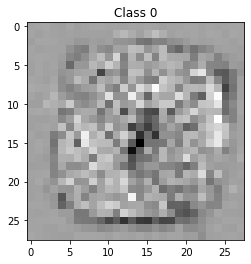

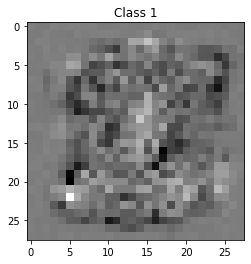

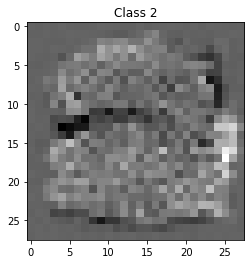

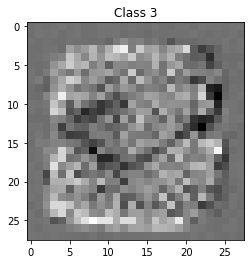

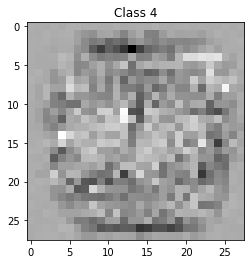

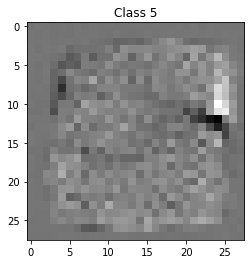

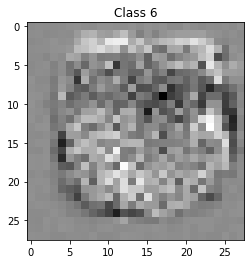

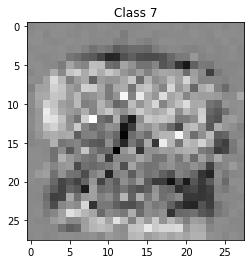

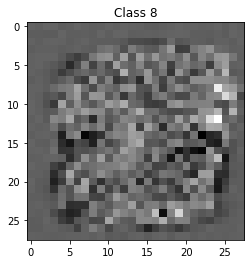

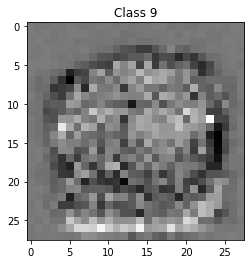

In [66]:
for parameter in network.parameters():
    for i in range(10):
        temp = torchvision.utils.make_grid(parameter[i].resize(28, 28))
        
        temp_np = temp.numpy()
        mx_val = np.amax(temp_np)
        mn_val = np.amin(temp_np)
        
        temp_np -= mn_val
        
        temp_np /= (mx_val - mn_val)
        
        plt.figure()
        plt.title("Class " + str(i))
        plt.imshow(np.transpose(temp_np, (1, 2, 0)))
        plt.show()
    
    break # we only need the first model parameter (weights)

In [67]:
limited_net = Net(num_inputs, num_outputs)
limited_optimizer = optim.SGD(network.parameters(), lr=lr)
# train only on 50 examples

def limited_train(epoch, train_loader):
    limited_net.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        
        if batch_idx >= 50:
            break
        
        data, target = Variable(data), Variable(target)
        limited_optimizer.zero_grad()
        output = limited_net(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        limited_optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def limited_test(test_loader):
    limited_net.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        #data, target = Variable(data, volatile=True), Variable(target)
        output = limited_net(data)
        test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
        #test_loss += F.cross_entropy(output, target, sum=True).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [68]:
# we shall use the same options

for i in range(1, epochs+1):
    limited_train(i, mnist_train_loader)

limited_test(mnist_test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.497182
Train Epoch: 2 [0/60000 (0%)]	Loss: 2.439223
Train Epoch: 3 [0/60000 (0%)]	Loss: 2.443267
Train Epoch: 4 [0/60000 (0%)]	Loss: 2.373773
Train Epoch: 5 [0/60000 (0%)]	Loss: 2.504015
Train Epoch: 6 [0/60000 (0%)]	Loss: 2.372546
Train Epoch: 7 [0/60000 (0%)]	Loss: 2.299996
Train Epoch: 8 [0/60000 (0%)]	Loss: 2.378237
Train Epoch: 9 [0/60000 (0%)]	Loss: 2.510677
Train Epoch: 10 [0/60000 (0%)]	Loss: 2.434117

Test set: Average loss: 2.4356, Accuracy: 1036/10000 (10%)



# **Answer (3):**
create needed blocks of code (and results) below

In [69]:
def temp_train(epoch, train_loader):
    '''Trains the data and returns the loss mean for the current epoch'''
    network.train()
    
    loss_epoch = []
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = network(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        
        loss_epoch.append(loss.item())
        
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    
    loss_mean_epoch = np.mean(loss_epoch)
    return loss_mean_epoch

In [70]:
class MultiLayerNet(nn.Module):
    '''Class for the required CNN in Q3 containing a new hidden layer with 1000 units in it'''
    
    def __init__(self, num_inputs, num_outputs):
        super(MultiLayerNet, self).__init__()
        self.linear1 = nn.Linear(num_inputs, 1000)
        self.linear2 = nn.Linear(1000, num_outputs)

    def forward(self, x):
        x = x.view(-1, num_inputs)
        x = self.linear1(x)
        x = self.linear2(x)
        x = torch.tanh(x)
        return x

In [71]:
lr = 0.01

train_loss_curves = [[], [], [], []]

for i in range(4):
    print("Learning Rate: " + str(lr), end=2*'\n')
    
    network = MultiLayerNet(28 ** 2, 10)
    optimizer = optim.SGD(network.parameters(), lr=lr)
    
    # training the new model with the current learning rate
    
    for j in range(1, epochs+1):
        curr_loss_avg = temp_train(j, mnist_train_loader)
        train_loss_curves[i].append(curr_loss_avg)

    test(mnist_test_loader)
    
    lr *= 10 # updating the learning rate

Learning Rate: 0.01

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.401371
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.301775
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.295392
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.164623
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.055797
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.133759
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.023733
Train Epoch: 1 [44800/60000 (75%)]	Loss: 1.095501
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.025154
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.122367
Train Epoch: 2 [0/60000 (0%)]	Loss: 1.146601
Train Epoch: 2 [6400/60000 (11%)]	Loss: 1.008295
Train Epoch: 2 [12800/60000 (21%)]	Loss: 1.130040
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.989322
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.961409
Train Epoch: 2 [32000/60000 (53%)]	Loss: 1.017966
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.918446
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.980595
Train Epoch: 2 [51200/60000 (85%)]	Loss: 1.010593
Train Epoch: 2 [57600/60000 (96%)]	Loss: 

Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.890300
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.977281
Train Epoch: 7 [38400/60000 (64%)]	Loss: 1.044796
Train Epoch: 7 [44800/60000 (75%)]	Loss: 0.980239
Train Epoch: 7 [51200/60000 (85%)]	Loss: 1.157139
Train Epoch: 7 [57600/60000 (96%)]	Loss: 1.072569
Train Epoch: 8 [0/60000 (0%)]	Loss: 1.027630
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.964099
Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.990613
Train Epoch: 8 [19200/60000 (32%)]	Loss: 0.965562
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.949603
Train Epoch: 8 [32000/60000 (53%)]	Loss: 0.949721
Train Epoch: 8 [38400/60000 (64%)]	Loss: 1.045035
Train Epoch: 8 [44800/60000 (75%)]	Loss: 0.940567
Train Epoch: 8 [51200/60000 (85%)]	Loss: 1.060699
Train Epoch: 8 [57600/60000 (96%)]	Loss: 1.014888
Train Epoch: 9 [0/60000 (0%)]	Loss: 1.135763
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.945341
Train Epoch: 9 [12800/60000 (21%)]	Loss: 1.018673
Train Epoch: 9 [19200/60000 (32%)]	Loss: 0.924775
Train Epoch:

Train Epoch: 3 [44800/60000 (75%)]	Loss: 2.421614
Train Epoch: 3 [51200/60000 (85%)]	Loss: 2.551758
Train Epoch: 3 [57600/60000 (96%)]	Loss: 2.640364
Train Epoch: 4 [0/60000 (0%)]	Loss: 2.551758
Train Epoch: 4 [6400/60000 (11%)]	Loss: 2.577864
Train Epoch: 4 [12800/60000 (21%)]	Loss: 2.640364
Train Epoch: 4 [19200/60000 (32%)]	Loss: 2.645508
Train Epoch: 4 [25600/60000 (43%)]	Loss: 2.583008
Train Epoch: 4 [32000/60000 (53%)]	Loss: 2.671614
Train Epoch: 4 [38400/60000 (64%)]	Loss: 2.609114
Train Epoch: 4 [44800/60000 (75%)]	Loss: 2.671614
Train Epoch: 4 [51200/60000 (85%)]	Loss: 2.583008
Train Epoch: 4 [57600/60000 (96%)]	Loss: 2.577864
Train Epoch: 5 [0/60000 (0%)]	Loss: 2.577864
Train Epoch: 5 [6400/60000 (11%)]	Loss: 2.515364
Train Epoch: 5 [12800/60000 (21%)]	Loss: 2.640364
Train Epoch: 5 [19200/60000 (32%)]	Loss: 2.645508
Train Epoch: 5 [25600/60000 (43%)]	Loss: 2.640364
Train Epoch: 5 [32000/60000 (53%)]	Loss: 2.609114
Train Epoch: 5 [38400/60000 (64%)]	Loss: 2.484114
Train Epoch:

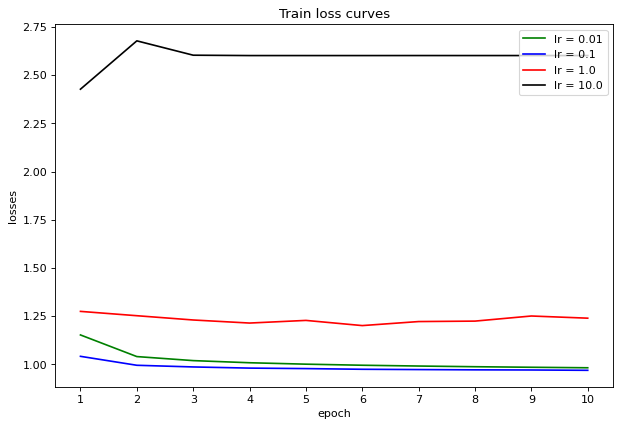

In [72]:
# plotting the loss curves for all four learning rates

colors = ['green', 'blue', 'red', 'black'] # the colors used for different lr in the plot

fg = plt.figure(figsize=(9, 6), dpi=80)
ax = fg.gca()

curr_lr = 0.01

for i in range(4):
    ax.plot(range(1, len(train_loss_curves[i]) + 1), train_loss_curves[i], '-', color=colors[i], label='lr = ' + str(curr_lr))
    curr_lr *= 10

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
plt.title('Train loss curves')

plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(loc="upper right")

plt.show()

# **Answer (4):**
create needed blocks of code (and results) below

In [73]:
dataset = 'cifar10'
lr = 0.01

In [74]:
class ConvNet(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_channels=1):
        super(ConvNet, self).__init__()
        
        # convolution layers
        self.conv1 = nn.Conv2d(num_inputs * num_channels, 16, 5, stride=2)
        self.conv2 = nn.Conv2d(16, 64, 3, stride=1)
        self.conv3 = nn.Conv2d(64, 64, 3, stride=1)
        
        # linear layers
        self.linear1 = nn.Linear(1600, 64)
        self.linear2 = nn.Linear(64, num_outputs)
    
    def forward(self, x):
        x = self.conv1(x)
        x = torch.tanh(x)
        x = self.conv2(x)
        x = torch.tanh(x)
        x = self.conv3(x)
        x = torch.tanh(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.linear1(x)
        x = torch.tanh(x)
        x = self.linear2(x)
        
        return x

In [75]:
epochs = 20
network = ConvNet(num_inputs=1, num_outputs=10, num_channels=3)
optimizer = optim.SGD(network.parameters(), lr=lr)
train_loss_curve = []

# train the new model and save the loss in the above list for the plot

for i in range(1, epochs+1):
    curr_loss_avg = temp_train(i, cifar_train_loader)
    train_loss_curve.append(curr_loss_avg)
    
test(cifar_test_loader)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.303008
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.266048
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.056372
Train Epoch: 1 [19200/50000 (38%)]	Loss: 2.018654
Train Epoch: 1 [25600/50000 (51%)]	Loss: 2.021667
Train Epoch: 1 [32000/50000 (64%)]	Loss: 2.036711
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.903059
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.924551
Train Epoch: 2 [0/50000 (0%)]	Loss: 1.762410
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.987042
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.778045
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.996136
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.903591
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.798935
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.900718
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.802549
Train Epoch: 3 [0/50000 (0%)]	Loss: 1.823914
Train Epoch: 3 [6400/50000 (13%)]	Loss: 1.618562
Train Epoch: 3 [12800/50000 (26%)]	Loss: 1.817203
Train Epoch: 3 [19200/50000 (38%)]	Loss: 1.535579
Train Epoch: 3 [25

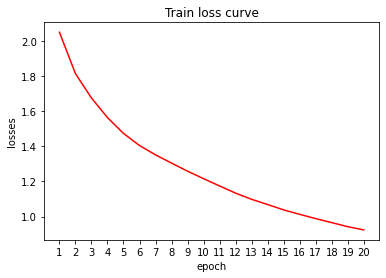

In [76]:
# plotting the loss curve for the training set

fg = plt.figure()
ax = fg.gca()
ax.plot(range(1, len(train_loss_curve) + 1), train_loss_curve, '-', color='red')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))

plt.xlabel('epoch')
plt.ylabel('losses')
plt.title('Train loss curve')

plt.show()

In [77]:
class ConvNetWithout3(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_channels=1):
        super(ConvNetWithout3, self).__init__()
        
        # convolution layers
        self.conv1 = nn.Conv2d(num_inputs * num_channels, 16, 5, stride=2)
        
        # linear layers
        self.linear1 = nn.Linear(784, 64)
        self.linear2 = nn.Linear(64, num_outputs)
    
    def forward(self, x):
        x = self.conv1(x)
        x = torch.tanh(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.linear1(x)
        x = torch.tanh(x)
        x = self.linear2(x)
        
        return x

In [78]:
epochs = 20
network = ConvNetWithout3(num_inputs=1, num_outputs=10, num_channels=3)
optimizer = optim.SGD(network.parameters(), lr=lr)
train_loss_curve = []

# train the new model and save the loss in the above list for the plot

for i in range(1, epochs+1):
    curr_loss_avg = temp_train(i, cifar_train_loader)
    train_loss_curve.append(curr_loss_avg)
    
test(cifar_test_loader)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.297473
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.133172
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.102983
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.997824
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.909470
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.884621
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.948228
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.834282
Train Epoch: 2 [0/50000 (0%)]	Loss: 1.814736
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.908740
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.774339
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.711925
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.679093
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.828539
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.720918
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.780919
Train Epoch: 3 [0/50000 (0%)]	Loss: 1.738079
Train Epoch: 3 [6400/50000 (13%)]	Loss: 1.633646
Train Epoch: 3 [12800/50000 (26%)]	Loss: 1.668715
Train Epoch: 3 [19200/50000 (38%)]	Loss: 1.433542
Train Epoch: 3 [25

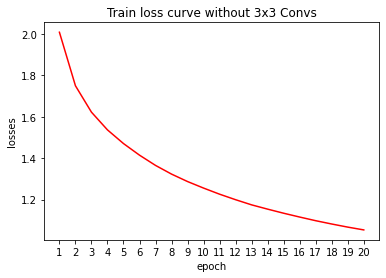

In [79]:
# plotting the loss curve for the training set

fg = plt.figure()
ax = fg.gca()
ax.plot(range(1, len(train_loss_curve) + 1), train_loss_curve, '-', color='red')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))

plt.xlabel('epoch')
plt.ylabel('losses')
plt.title('Train loss curve without 3x3 Convs')

plt.show()